# Structure of Notebook

1. Problem Statement
2. Loading Libraries and Data
3. Data Preprocessing(Outliers & Missing values)
4. Feature extraction and exploration
5. Training and Validation data
6. Time Series Forecasting models
7. Machine Learning models

# 1. Problem Statement

SimpleBuy is a clothing company. Be it parent, child, man, woman, they have wide range of products catering to the need to every individual. They aim to become one stop destination for all clothing desires.
 
Their idea of offline and online channels is doing quite well. Their stock now runs out even faster than they could replenish it. Customers are no longer skeptical about their quality. Their offline stores help customer to physically check clothes before buying them, especially the expensive clothes. In addition, their delivery channels are known to achieve six sigma efficiency.
 
However, SimpleBuy can only provide this experience, if they can manage the stocks well. Hence, they need to forecast the sales ahead of time. And this is where you will help them in collecting the raw material and planning the manufacturing process. SimpleBuy has provided their Sales data for last 2 years and they want to predict the sales for next 6 months.

# 2. Loading the Libraries and the Data

In [1]:
#importing required libraries
import pandas as pd
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt 
%matplotlib inline

from sklearn.metrics import mean_squared_log_error
from math import sqrt
from statistics import mean, stdev

import warnings
warnings.filterwarnings("ignore")

In [2]:
# loading the data
data = pd.read_csv("data/Train_KQyJ5eh.csv")

In [3]:
data.shape

(587, 2)

In [4]:
data.head()

,Date,Number_SKU_Sold
0,1-Jan-07,31762
1,2-Jan-07,285955
2,3-Jan-07,740781
3,4-Jan-07,508796
4,5-Jan-07,445951


In [5]:
data.tail()

,Date,Number_SKU_Sold
582,20-Dec-08,10572461
583,21-Dec-08,11507413
584,22-Dec-08,13640882
585,23-Dec-08,8821786
586,24-Dec-08,192532706


- We have daily sales data for two years, starting from 1-jan-07 to 24-dec-08.
- Using this historical data, we need to forecast the demand expected in the next 6 months. 

Let us do some basic exploration and find out if the given data has any trend or seasonal patterns.

# 3. Preprocessing the Data

### Plotting Time Series

In [6]:
data['Date'] = pd.to_datetime(data['Date'], format='%d-%b-%y')
data.index = data['Date']

In [7]:
data.head()

,Date,Number_SKU_Sold
Date,,
2007-01-01,2007-01-01,31762
2007-01-02,2007-01-02,285955
2007-01-03,2007-01-03,740781
2007-01-04,2007-01-04,508796
2007-01-05,2007-01-05,445951


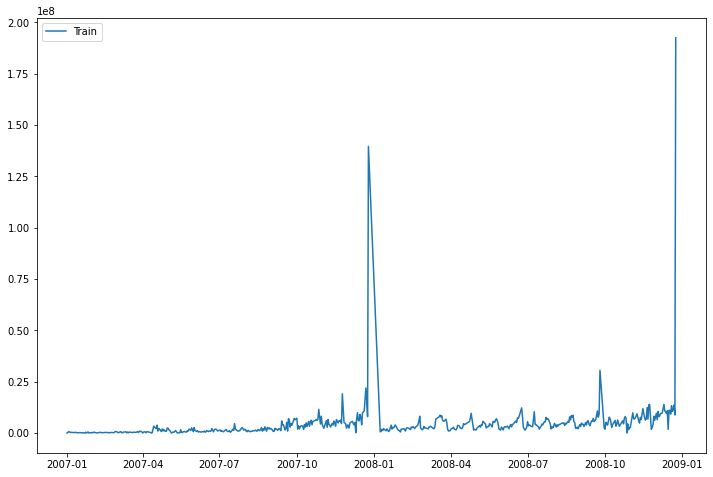

In [8]:
plt.figure(figsize=(12,8))

plt.plot(data.index, data['Number_SKU_Sold'], label='Train')
plt.legend(loc='best')
plt.show()

- Clearly there are some very high values in the data. 
- Could this be around holiday season like new year's? Let us find out

### Outliers in Data

In [9]:
data['Number_SKU_Sold'].describe()

count    5.870000e+02
mean     4.118112e+06
std      1.015100e+07
min      3.176200e+04
25%      1.075948e+06
50%      2.784444e+06
75%      5.208588e+06
max      1.925327e+08
Name: Number_SKU_Sold, dtype: float64

In [10]:
print('Value at 95th percentile:', (np.percentile(data['Number_SKU_Sold'], 95)))
print('Value at 97th percentile:', (np.percentile(data['Number_SKU_Sold'], 97)))
print('Value at 99th percentile:', (np.percentile(data['Number_SKU_Sold'], 99)))

Value at 95th percentile: 9855528.099999992
Value at 97th percentile: 10975127.499999993
Value at 99th percentile: 14225472.619999975


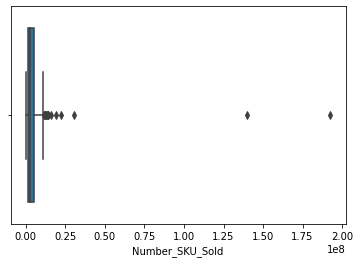

In [11]:
sns.boxplot(data['Number_SKU_Sold'])

In [12]:
IQR = (np.percentile(data['Number_SKU_Sold'], 75)) - (np.percentile(data['Number_SKU_Sold'], 25))
whisker_val = (np.percentile(data['Number_SKU_Sold'], 75)) + (1.5*(IQR))
whisker_val

11407547.25

In [13]:
# number of values greater than whisker value
data.loc[data['Number_SKU_Sold']>whisker_val].shape[0]

16

In [14]:
# number of values greater than 95th percentile
data.loc[data['Number_SKU_Sold'] > np.percentile(data['Number_SKU_Sold'], 95)].shape[0]

30

- We can use either the 95th percentile value or whisker value to select outliers
- There are 16 points greater than whisker value
- Replace the outliers with bfill or ffill

In [15]:
data.loc[data['Number_SKU_Sold']>whisker_val]

,Date,Number_SKU_Sold
Date,,
2007-10-27,2007-10-27,11572492
2007-11-24,2007-11-24,19138073
2007-12-22,2007-12-22,21956074
2007-12-23,2007-12-23,15766750
2007-12-25,2007-12-25,139629635
2008-06-24,2008-06-24,12288917
2008-09-25,2008-09-25,30579435
2008-11-15,2008-11-15,11930320
2008-11-20,2008-11-20,12416871


In [16]:
data_original = data['Number_SKU_Sold']
data['Number_SKU_Sold'] = data['Number_SKU_Sold'].apply(lambda x: np.nan if x > whisker_val else x) 

In [17]:
data['Number_SKU_Sold'].isnull().sum()

16

In [18]:
# removing outliers using ffill
data['Number_SKU_Sold'] = data['Number_SKU_Sold'].fillna(method ='ffill')

In [19]:
data['Number_SKU_Sold'].isnull().sum()

0

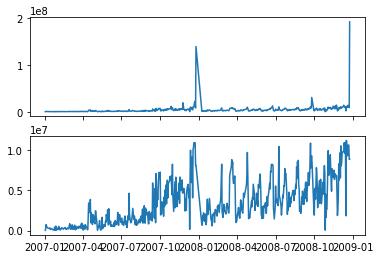

In [20]:
fig, axs = plt.subplots(2, 1,  sharex=True)

axs[0].plot(data_original,) 
axs[1].plot(data['Number_SKU_Sold'])
  
plt.show() 

### Missing Date Values in Data

In [21]:
data['Date'].min(), data['Date'].max()

(Timestamp('2007-01-01 00:00:00'), Timestamp('2008-12-24 00:00:00'))

In [22]:
print('Total days between 01-jan-07 to 24-Dec-08:', (data['Date'].max() - data['Date'].min()).days)
print('Number of rows present in the data are:', data.shape[0])

Total days between 01-jan-07 to 24-Dec-08: 723
Number of rows present in the data are: 587


In [23]:
724/7

103.42857142857143

In [24]:
pd.date_range(start = '2007-01-01', end = '2008-12-24' ).difference(data.index)

DatetimeIndex(['2007-01-07', '2007-01-08', '2007-01-10', '2007-01-14',
               '2007-01-17', '2007-01-21', '2007-01-25', '2007-01-28',
               '2007-02-04', '2007-02-10',
               ...
               '2008-11-01', '2008-11-02', '2008-11-07', '2008-11-09',
               '2008-11-14', '2008-11-16', '2008-11-24', '2008-11-30',
               '2008-12-07', '2008-12-09'],
              dtype='datetime64[ns]', length=137, freq=None)

- There are 137 days missing over the span of two years. 
- Are these weekends? Or Holidays? 
- Are these days missing at random?

Let's find out

In [25]:
start_date = '2007-01-01'
end_date = '2008-12-24'

In [26]:
missing_dates = pd.DataFrame(data = pd.date_range(start = start_date, end = end_date).difference(data.index), 
                             columns= ['Date'])

In [27]:
missing_dates['Day'] = missing_dates['Date'].dt.strftime("%A")
missing_dates['Month'] = missing_dates['Date'].dt.month
missing_dates['year'] = missing_dates['Date'].dt.year

In [28]:
missing_dates.head(5)

,Date,Day,Month,year
0,2007-01-07,Sunday,1,2007
1,2007-01-08,Monday,1,2007
2,2007-01-10,Wednesday,1,2007
3,2007-01-14,Sunday,1,2007
4,2007-01-17,Wednesday,1,2007


In [29]:
missing_dates['Day'].value_counts()

Sunday       86
Saturday     14
Friday       10
Monday       10
Thursday      6
Wednesday     6
Tuesday       5
Name: Day, dtype: int64

In [30]:
missing_dates['Month'].value_counts()

1     19
9     13
7     13
6     13
11    12
3     12
12    10
10    10
5     10
4      9
2      9
8      7
Name: Month, dtype: int64

In [31]:
pd.crosstab(missing_dates['year'], missing_dates['Day'])

Day,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday
year,,,,,,,
2007,3,4,6,43,5,1,5
2008,7,6,8,43,1,4,1


- Most of the missing days are Sundays
- Remaining 51 missing days are from Mon-Fri
- January has seen most of the missing days

Conclusions:
1. We will not make predictions for Sunday
2. We will make predictions for all weekdays
3. Discuss with stakeholders for manual adjustments on Sunday and holiday

### Dealing with Missing Values

In [32]:
# add rows for missing days
data_ = pd.DataFrame(data['Number_SKU_Sold'])
data_.index = pd.DatetimeIndex(data.Date)

In [33]:
data_.head(10)

,Number_SKU_Sold
Date,
2007-01-01,31762.0
2007-01-02,285955.0
2007-01-03,740781.0
2007-01-04,508796.0
2007-01-05,445951.0
2007-01-06,347351.0
2007-01-09,269415.0
2007-01-11,286603.0
2007-01-12,334356.0


In [34]:
# add missing dates to the data
idx = pd.date_range('2007-01-01', '2008-12-24')
data_ = data_.reindex(idx, fill_value=0)

In [35]:
data_.head(9)

,Number_SKU_Sold
2007-01-01,31762.0
2007-01-02,285955.0
2007-01-03,740781.0
2007-01-04,508796.0
2007-01-05,445951.0
2007-01-06,347351.0
2007-01-07,0.0
2007-01-08,0.0
2007-01-09,269415.0


In [36]:
# extract weekday from the dates
data_['Date'] = data_.index
data_['weekday_name'] = data_['Date'].dt.strftime("%A")
data_.shape

(724, 3)

In [37]:
data_.head()

,Number_SKU_Sold,Date,weekday_name
2007-01-01,31762.0,2007-01-01,Monday
2007-01-02,285955.0,2007-01-02,Tuesday
2007-01-03,740781.0,2007-01-03,Wednesday
2007-01-04,508796.0,2007-01-04,Thursday
2007-01-05,445951.0,2007-01-05,Friday


In [38]:
# remove sundays from data
data_ = data_.loc[data_['weekday_name']!= 'Sunday']
data_.shape

(621, 3)

In [39]:
data_original = data['Number_SKU_Sold']
data_['Number_SKU_Sold'] = data_['Number_SKU_Sold'].apply(lambda x: np.nan if x == 0.0 else x)
data_.isnull().sum()

Number_SKU_Sold    51
Date                0
weekday_name        0
dtype: int64

In [40]:
# impute missing values
data_['Number_SKU_Sold'] = data_['Number_SKU_Sold'].fillna(method ='ffill')

In [41]:
data_.isnull().sum()

Number_SKU_Sold    0
Date               0
weekday_name       0
dtype: int64

# 4. Feature Extraction and Exploration

### Decompose Series

In [42]:
from statsmodels.tsa.seasonal import seasonal_decompose

decomposed_series = seasonal_decompose(data_['Number_SKU_Sold'], freq=6)

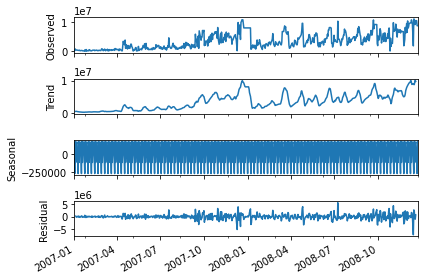

In [43]:
decomposed_series.plot()
plt.show()

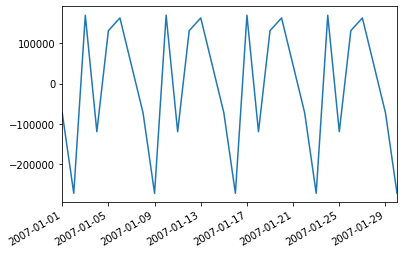

In [44]:
# considering 26 days a month 
decomposed_series.seasonal[0:26].plot()

- Pattern repeats 4 times a month
- This suggests weekly seasonality in the data

In [45]:
data_feat = pd.DataFrame({"year": data_['Date'].dt.year,
                          "month": data_['Date'].dt.month,
                          "day": data_['Date'].dt.day,
                          "weekday": data_['Date'].dt.dayofweek,
                          "weekday_name":data_['Date'].dt.strftime("%A"),
                          "dayofyear": data_['Date'].dt.dayofyear,
                          "week": data_['Date'].dt.week,
                          "quarter": data_['Date'].dt.quarter,
                         })

In [46]:
complete_data = pd.concat([data_feat, data_['Number_SKU_Sold']], axis=1)
complete_data.head()

,year,month,day,weekday,weekday_name,dayofyear,week,quarter,Number_SKU_Sold
2007-01-01,2007,1,1,0,Monday,1,1,1,31762.0
2007-01-02,2007,1,2,1,Tuesday,2,1,1,285955.0
2007-01-03,2007,1,3,2,Wednesday,3,1,1,740781.0
2007-01-04,2007,1,4,3,Thursday,4,1,1,508796.0
2007-01-05,2007,1,5,4,Friday,5,1,1,445951.0


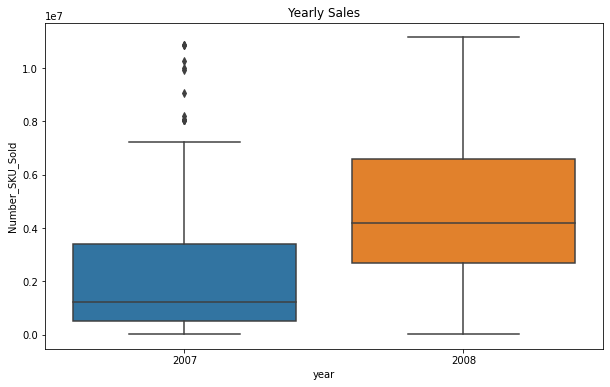

In [47]:
# boxplot for yearly sale
plt.figure(figsize=(10,6))

sns.boxplot(x=complete_data['year'], y=complete_data['Number_SKU_Sold'], )
plt.title('Yearly Sales')
plt.show()

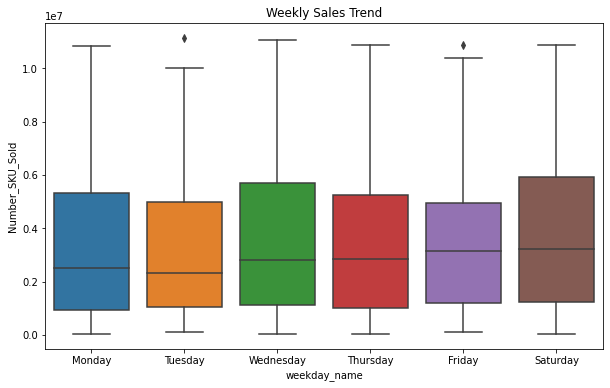

In [48]:
# boxplot for week's sales
plt.figure(figsize=(10,6))

sns.boxplot(x=complete_data['weekday_name'], y=complete_data['Number_SKU_Sold'], )
plt.title('Weekly Sales Trend')
plt.show()

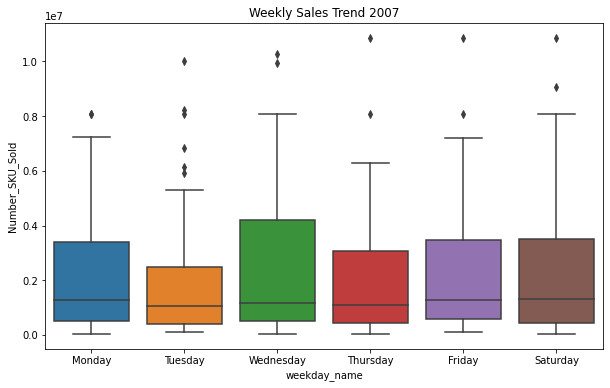

In [49]:
# boxplot for week's sales 2007
plt.figure(figsize=(10,6))

sns.boxplot(x=complete_data[complete_data["year"]==2007]['weekday_name'], y=complete_data['Number_SKU_Sold'])
plt.title('Weekly Sales Trend 2007')
plt.show()

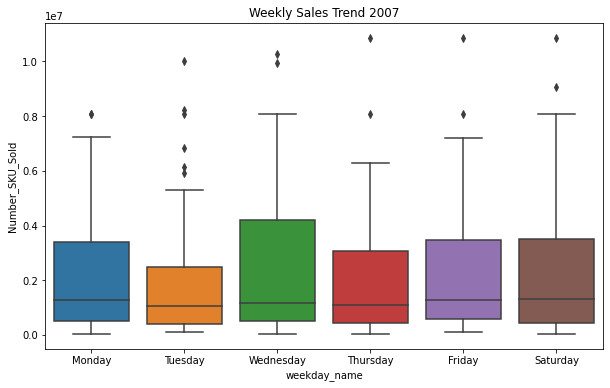

In [51]:
# boxplot for week's sales 2007
plt.figure(figsize=(10,6))

sns.boxplot(x=complete_data[complete_data["year"]==2007]['weekday_name'], y=complete_data[complete_data.year==2007]['Number_SKU_Sold'])
plt.title('Weekly Sales Trend 2007')
plt.show()

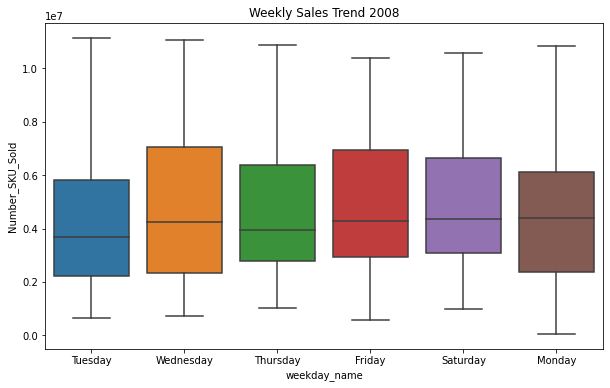

In [52]:
# boxplot for week's sales 2008
plt.figure(figsize=(10,6))

sns.boxplot(x=complete_data[complete_data["year"]==2008]['weekday_name'], y=complete_data[complete_data.year==2008]['Number_SKU_Sold'])
plt.title('Weekly Sales Trend 2008')
plt.show()

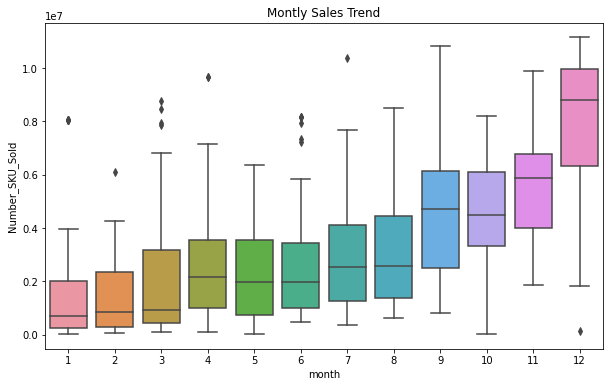

In [53]:
# boxplot for monthly sales
plt.figure(figsize=(10,6))

sns.boxplot(x=complete_data['month'], y=complete_data['Number_SKU_Sold'])
plt.title('Montly Sales Trend')
plt.show()

In [54]:
complete_data.head()

,year,month,day,weekday,weekday_name,dayofyear,week,quarter,Number_SKU_Sold
2007-01-01,2007,1,1,0,Monday,1,1,1,31762.0
2007-01-02,2007,1,2,1,Tuesday,2,1,1,285955.0
2007-01-03,2007,1,3,2,Wednesday,3,1,1,740781.0
2007-01-04,2007,1,4,3,Thursday,4,1,1,508796.0
2007-01-05,2007,1,5,4,Friday,5,1,1,445951.0


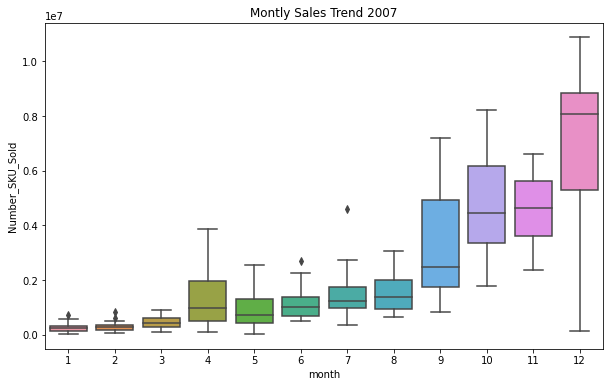

In [55]:
# boxplot for monthly sales
plt.figure(figsize=(10,6))

sns.boxplot(x=complete_data[complete_data["year"]==2007]['month'], y=complete_data['Number_SKU_Sold'])
plt.title('Montly Sales Trend 2007')
plt.show()

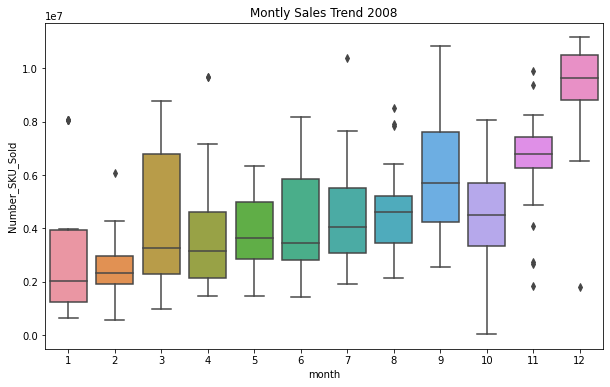

In [56]:
# boxplot for monthly sales
plt.figure(figsize=(10,6))

sns.boxplot(x=complete_data[complete_data["year"]==2008]['month'], y=complete_data[complete_data["year"]==2008]['Number_SKU_Sold'], )
plt.title('Montly Sales Trend 2008')
plt.show()

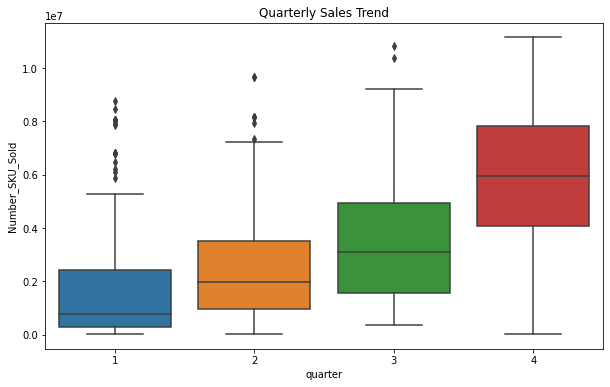

In [57]:
# boxplot for quarterly sales
plt.figure(figsize=(10,6))

sns.boxplot(x=complete_data['quarter'], y=complete_data['Number_SKU_Sold'])
plt.title('Quarterly Sales Trend')
plt.show()

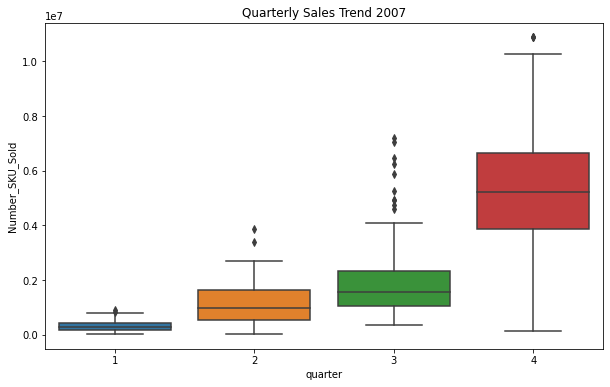

In [58]:
# boxplot for quarterly sales 2007
plt.figure(figsize=(10,6))

sns.boxplot(x=complete_data[complete_data.year==2007]['quarter'], y=complete_data[complete_data.year==2007]['Number_SKU_Sold'])
plt.title('Quarterly Sales Trend 2007')
plt.show()

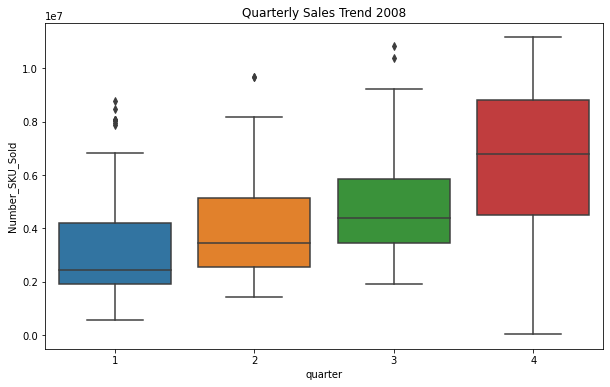

In [59]:
# boxplot for quarterly sales 2007
plt.figure(figsize=(10,6))

sns.boxplot(x=complete_data[complete_data.year==2008]['quarter'], y=complete_data[complete_data.year==2008]['Number_SKU_Sold'])
plt.title('Quarterly Sales Trend 2008')
plt.show()

In [60]:
complete_data[complete_data.year==2007]["Number_SKU_Sold"].sum()/complete_data[complete_data.year==2007]["Number_SKU_Sold"].shape[0]

2275010.9361022366

In [61]:
complete_data[complete_data.year==2008]["Number_SKU_Sold"].sum()/complete_data[complete_data.year==2008]["Number_SKU_Sold"].shape[0]

4715161.0032467535

- Except for a few high sales in 2007, sales were comparatively higher in 2008
- All weekdays have similar trend on sales
- Average sales are higher towards the end of the year
- Quarter 4 has the maximum sales
- Average sales (2007): 2275011
- Avaregae sales (2008): 4715161

# 5. Holdout Validation

In [62]:
data_.head()

,Number_SKU_Sold,Date,weekday_name
2007-01-01,31762.0,2007-01-01,Monday
2007-01-02,285955.0,2007-01-02,Tuesday
2007-01-03,740781.0,2007-01-03,Wednesday
2007-01-04,508796.0,2007-01-04,Thursday
2007-01-05,445951.0,2007-01-05,Friday


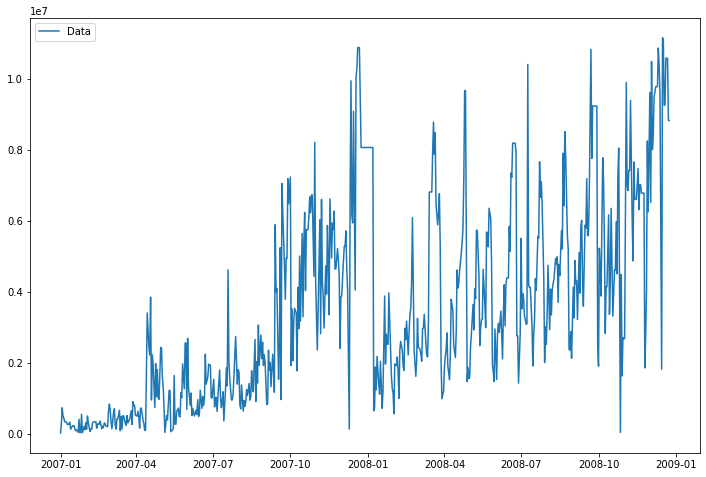

In [63]:
plt.figure(figsize=(12,8))

plt.plot(data_.index, data_['Number_SKU_Sold'], label = 'Data')
plt.legend(loc='best')
plt.show()

In [64]:
# dividing into train and validation sets

train_data = data_[:469]
valid_data = data_[469:]

In [65]:
valid_data.tail()

,Number_SKU_Sold,Date,weekday_name
2008-12-19,9254530.0,2008-12-19,Friday
2008-12-20,10572461.0,2008-12-20,Saturday
2008-12-22,10572461.0,2008-12-22,Monday
2008-12-23,8821786.0,2008-12-23,Tuesday
2008-12-24,8821786.0,2008-12-24,Wednesday


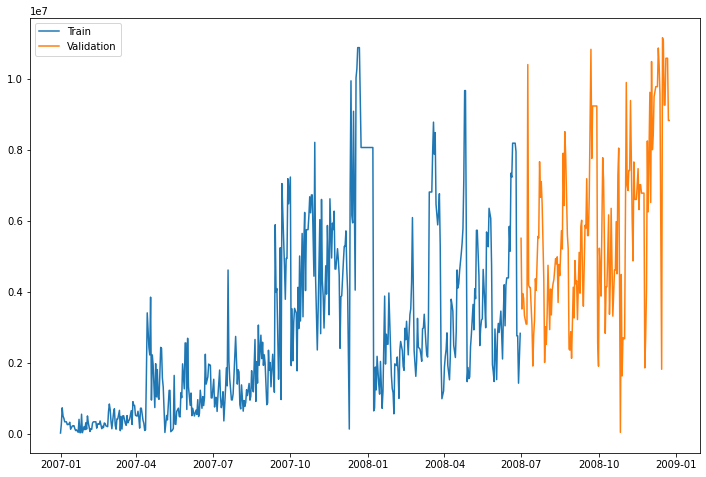

In [66]:
plt.figure(figsize=(12,8))

plt.plot(train_data.index, train_data['Number_SKU_Sold'], label='Train')
plt.plot(valid_data.index, valid_data['Number_SKU_Sold'], label='Validation')
plt.legend(loc='best')
plt.show()

In [67]:
def rmsle(actual, preds):
    for i in range(0,len(preds)):
        if preds[i]<0:
            preds[i] = 0
        else:
            pass
    
    error = (sqrt(mean_squared_log_error(actual, preds)))*100
    return error

# 6. Time Series Forecasting Models

### Holt's Winters (aka triple enponential smoothing)

In [68]:
#importing module
from statsmodels.tsa.api import ExponentialSmoothing

In [69]:
#training the model
model = ExponentialSmoothing(np.asarray(train_data['Number_SKU_Sold']), seasonal_periods=6, trend='add', seasonal='add')
model = model.fit(smoothing_level=0.2, smoothing_slope=0.001, smoothing_seasonal=0.2)
    
# predictions and evaluation
preds = model.forecast(len(valid_data)) 
score = rmsle(valid_data['Number_SKU_Sold'], preds)

# results
print('RMSLE for Holt Winter is:', score)

RMSLE for Holt Winter is: 58.12309298891968


## Grid search

In [70]:
from itertools import product
from tqdm import tqdm_notebook

In [71]:
# setting initial values and some bounds for them
level = [0.1, 0.3, 0.5, 0.8]
smoothing_slope = [0.0001, 0.001, 0.05] 
smoothing_seasonal = [0.2, 0.4, 0.6]

# creating list with all the possible combinations of parameters
parameters = product(level, smoothing_slope, smoothing_seasonal)
parameters_list = list(parameters)
len(parameters_list)

36

In [72]:
parameters_list[:5]

[(0.1, 0.0001, 0.2),
 (0.1, 0.0001, 0.4),
 (0.1, 0.0001, 0.6),
 (0.1, 0.001, 0.2),
 (0.1, 0.001, 0.4)]

In [73]:
def grid_search(parameters_list):
    
    results = []
    best_error_ = float("inf")

    #for param in tqdm_notebook(parameters_list):
    for param in parameters_list:
        #training the model
        model = ExponentialSmoothing(np.asarray(train_data['Number_SKU_Sold']), seasonal_periods=6, trend='add', seasonal='add')
        model = model.fit(smoothing_level=param[0], smoothing_slope=param[1], smoothing_seasonal=param[2])

        # predictions and evaluation
        preds = model.forecast(len(valid_data)) 
        score = rmsle(valid_data['Number_SKU_Sold'], preds)
        
        # saving best model, rmse and parameters
        if score < best_error_:
            best_model = model
            best_error_ = score
            best_param = param
        results.append([param, score])
        
    result_table = pd.DataFrame(results)
    result_table.columns = ['parameters', 'RMSLE']
    
    
    # sorting in ascending order, the lower rmse is - the better
    result_table = result_table.sort_values(by='RMSLE', ascending=True).reset_index(drop=True)
    
    return result_table

In [74]:
result_table = grid_search(parameters_list)

In [75]:
result_table[:5]

,parameters,RMSLE
0,"(0.1, 0.001, 0.2)",58.274963
1,"(0.1, 0.0001, 0.2)",58.279505
2,"(0.1, 0.0001, 0.4)",60.932206
3,"(0.1, 0.001, 0.4)",60.950287
4,"(0.1, 0.05, 0.4)",61.243131


In [76]:
#training the model
model = ExponentialSmoothing(np.asarray(train_data['Number_SKU_Sold']), seasonal_periods=6, trend='add', seasonal='add')
model = model.fit(smoothing_level=0.1, smoothing_slope=0.0001, smoothing_seasonal=0.2)
    
# predictions and evaluation
preds = model.forecast(len(valid_data)) 
score = rmsle(valid_data['Number_SKU_Sold'], preds)

# results
print('RMSLE for Holt Winter is:', score)

RMSLE for Holt Winter is: 58.27950467646268


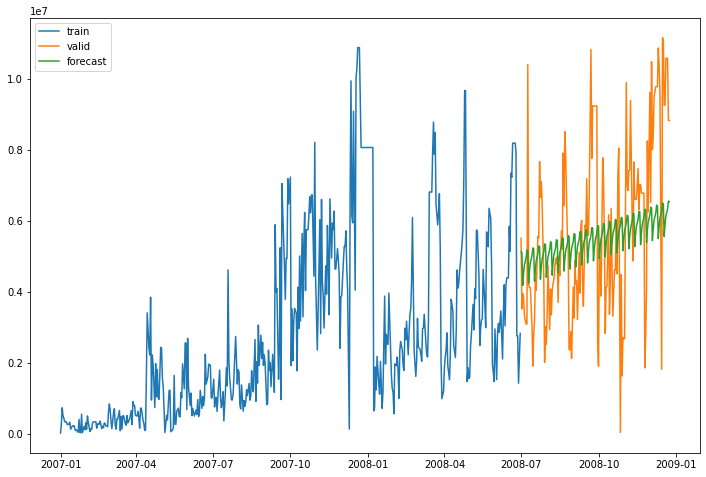

In [77]:
plt.figure(figsize = (12,8))

plt.plot(train_data.index , train_data['Number_SKU_Sold'], label = 'train')
plt.plot(valid_data.index , valid_data['Number_SKU_Sold'], label = 'valid')
plt.plot(valid_data.index , preds, label = 'forecast')
plt.legend(loc='best')

plt.show()

# SARIMA Model

### Stationarity Test

In [82]:
# dickey fuller
from statsmodels.tsa.stattools import adfuller

In [83]:
def adf_test(timeseries):
    
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput=pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])

    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

In [84]:
adf_test(data_['Number_SKU_Sold'])

Results of Dickey-Fuller Test:
Test Statistic                  -2.384756
p-value                          0.146085
#Lags Used                      13.000000
Number of Observations Used    607.000000
Critical Value (1%)             -3.441169
Critical Value (5%)             -2.866313
Critical Value (10%)            -2.569312
dtype: float64


 If the test statistic is less than the critical value, we can reject the null hypothesis (aka the series is stationary). When the test statistic is greater than the critical value, we fail to reject the null hypothesis (which means the series is not stationary). **Here test statistic is > than critical. Hence series is not stationary**

### Making Series Stationary

In [85]:
def inverse_boxcox(y, lambda_):
    return np.exp(y) if lambda_ == 0 else np.exp(np.log(lambda_ * y + 1) / lambda_)

In [86]:
from scipy import stats
train_data['Number_SKU_Sold_log'], lambda_ar = stats.boxcox(train_data['Number_SKU_Sold'])
lambda_ar

0.275245566091353

In [87]:
train_data['Number_SKU_Sold_log_diff']=train_data['Number_SKU_Sold_log']-train_data['Number_SKU_Sold_log'].shift(6)

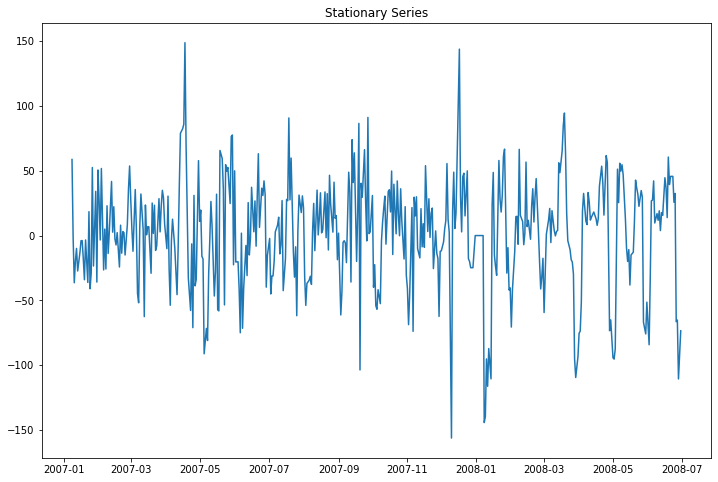

In [88]:
plt.figure(figsize=(12,8))

plt.plot(train_data.index, train_data['Number_SKU_Sold_log_diff'])
plt.title("Stationary Series")
plt.show()

In [89]:
train_data['Number_SKU_Sold_log_diff_diff']=train_data['Number_SKU_Sold_log_diff']-train_data['Number_SKU_Sold_log_diff'].shift(1)

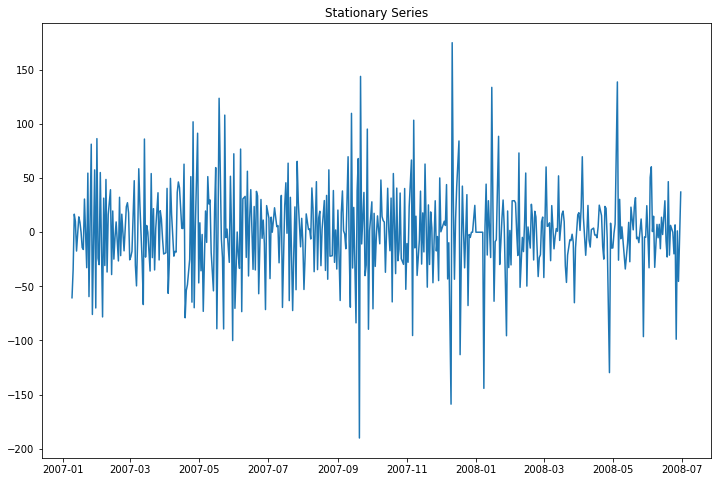

In [90]:
plt.figure(figsize=(12,8))

plt.plot(train_data.index, train_data['Number_SKU_Sold_log_diff_diff'])
plt.title("Stationary Series")
plt.show()

### Building Sarima Model

In [91]:
from statsmodels.tsa.statespace import sarimax
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

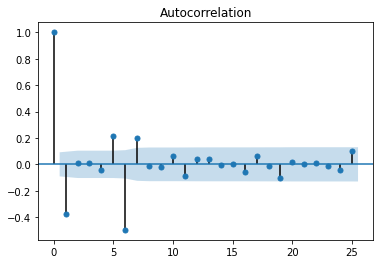

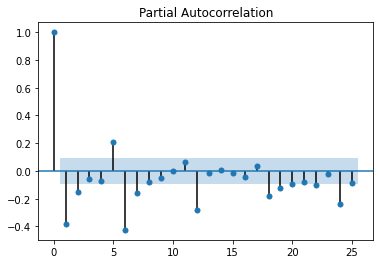

In [92]:
plot_acf(train_data['Number_SKU_Sold_log_diff_diff'].dropna(), lags=25)
plot_pacf(train_data['Number_SKU_Sold_log_diff_diff'].dropna(), lags=25)
plt.show()

In [93]:
#training the model
model = sarimax.SARIMAX(train_data['Number_SKU_Sold_log'], seasonal_order=(1,1,2,6), order=(1,1,2))
model = model.fit()

In [94]:
# predictions and evaluation
end = len(train_data) + len(valid_data)
preds = inverse_boxcox(model.predict(start=0, end=end)[len(train_data)+1:], lambda_ar) 
preds = (preds.reset_index())[0] # storing validation predictions

In [95]:
# results
score = rmsle(valid_data['Number_SKU_Sold'], preds)
print('RMSLE for SARIMA model Forecasts is', score)

RMSLE for SARIMA model Forecasts is 57.59403941855498


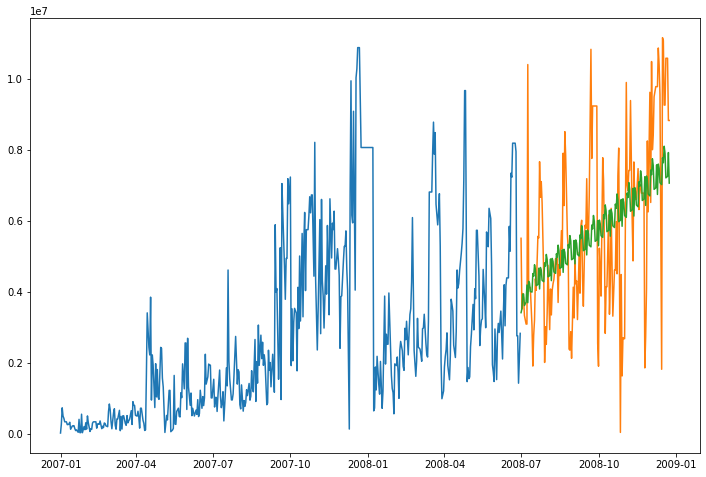

In [96]:
plt.figure(figsize = (12,8))
plt.plot(train_data.index, train_data['Number_SKU_Sold'], label = 'train')
plt.plot(valid_data.index, valid_data['Number_SKU_Sold'], label = 'valid')
plt.plot(valid_data.index, preds, label = 'preds')
plt.show()

# 6. Building ML Models

In [97]:
complete_data.head()

,year,month,day,weekday,weekday_name,dayofyear,week,quarter,Number_SKU_Sold
2007-01-01,2007,1,1,0,Monday,1,1,1,31762.0
2007-01-02,2007,1,2,1,Tuesday,2,1,1,285955.0
2007-01-03,2007,1,3,2,Wednesday,3,1,1,740781.0
2007-01-04,2007,1,4,3,Thursday,4,1,1,508796.0
2007-01-05,2007,1,5,4,Friday,5,1,1,445951.0


In [98]:
train_data = complete_data[:469]
valid_data = complete_data[469:]

In [99]:
valid_data.head()

,year,month,day,weekday,weekday_name,dayofyear,week,quarter,Number_SKU_Sold
2008-07-01,2008,7,1,1,Tuesday,183,27,3,5508723.0
2008-07-02,2008,7,2,2,Wednesday,184,27,3,3519382.0
2008-07-03,2008,7,3,3,Thursday,185,27,3,3955195.0
2008-07-04,2008,7,4,4,Friday,186,27,3,3832665.0
2008-07-05,2008,7,5,5,Saturday,187,27,3,3336381.0


### Linear Regression Model

In [100]:
from sklearn.linear_model import LinearRegression

In [101]:
# separating features and target variable
x_train = train_data.drop(['Number_SKU_Sold','weekday_name'], axis=1)
y_train = train_data['Number_SKU_Sold']

x_valid = valid_data.drop(['Number_SKU_Sold', 'weekday_name'], axis=1)
y_valid = valid_data['Number_SKU_Sold']

In [102]:
#training the model
model = LinearRegression(normalize=True)
model.fit(x_train, y_train)
preds = model.predict(x_valid)

# results
score = rmsle(y_valid, preds)

print('RMSLE for Linear Regression is', score)

RMSLE for Linear Regression is 63.740634612433446


In [103]:
feature_coeff = pd.DataFrame(zip(x_train.columns, model.coef_), columns=['Feature', 'coeff'])
feature_coeff

,Feature,coeff
0,year,2.766191e+06
1,month,-1.105272e+07
2,day,-3.348308e+05
3,weekday,7.092769e+04
4,dayofyear,3.876719e+05
5,week,-4.547954e+04
6,quarter,-9.355057e+04


<BarContainer object of 7 artists>

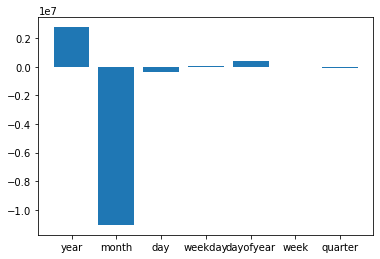

In [104]:
plt.bar(feature_coeff['Feature'], feature_coeff['coeff'])

 # Regularization for Linear Regression

In [105]:
from sklearn.linear_model import Ridge

In [106]:
# target encoding
# month level encoding
monthly_average = pd.DataFrame(train_data.groupby('month')['Number_SKU_Sold'].mean())
train_data['monthly_average'] = train_data['month'].map(monthly_average.Number_SKU_Sold)
valid_data['monthly_average'] = valid_data['month'].map(monthly_average.Number_SKU_Sold)


# week target encoding
week_average = pd.DataFrame(train_data.groupby('weekday')['Number_SKU_Sold'].mean())
train_data['week_average'] = train_data['weekday'].map(week_average.Number_SKU_Sold)
valid_data['week_average'] = valid_data['weekday'].map(week_average.Number_SKU_Sold)

In [107]:
# separating features and target variable
x_train = train_data.drop(['Number_SKU_Sold','weekday_name'], axis=1)
y_train = train_data['Number_SKU_Sold']

x_valid = valid_data.drop(['Number_SKU_Sold', 'weekday_name'], axis=1)
y_valid = valid_data['Number_SKU_Sold']

In [108]:
for alpha in [0.01, 0.05, 0.1, 0.5, 1, 5]:
    print('----- ----- ----- ----- -----')
    print('At alpha value:', alpha)

    #training the model
    model = Ridge(alpha = alpha, normalize=True)
    model.fit(x_train, y_train)

    # predictions 
    preds = model.predict(x_valid)
    score = rmsle(y_valid, preds)

    # results
    print('Linear Regression error is', score)

----- ----- ----- ----- -----
At alpha value: 0.01
Linear Regression error is 60.855625268768065
----- ----- ----- ----- -----
At alpha value: 0.05
Linear Regression error is 60.145324353523996
----- ----- ----- ----- -----
At alpha value: 0.1
Linear Regression error is 59.46392298686046
----- ----- ----- ----- -----
At alpha value: 0.5
Linear Regression error is 57.17547364492817
----- ----- ----- ----- -----
At alpha value: 1
Linear Regression error is 57.41635463193909
----- ----- ----- ----- -----
At alpha value: 5
Linear Regression error is 66.49035501312332


In [109]:
#training the model
model = Ridge(alpha = 0.5, normalize=True)
model.fit(x_train, y_train)

# predictions 
preds = model.predict(x_valid)
score = rmsle(y_valid, preds)

# results
print('Linear Regression error is', score)

Linear Regression error is 57.17547364492817


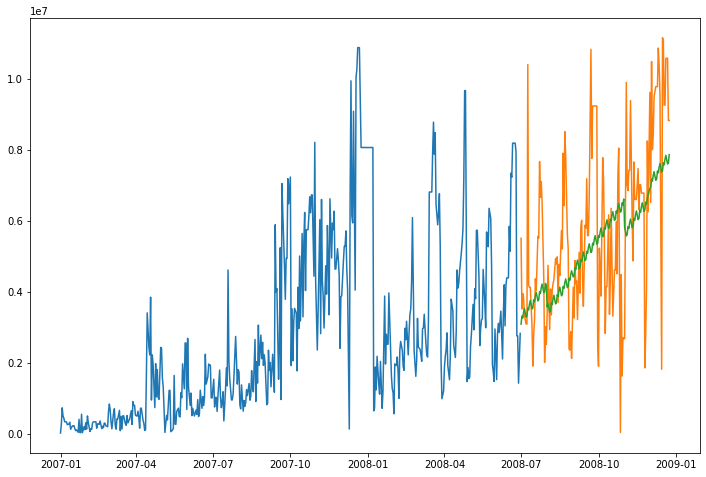

In [110]:
plt.figure(figsize=(12,8))
plt.plot(train_data.index, train_data['Number_SKU_Sold'], label = 'train')
plt.plot(valid_data.index, valid_data['Number_SKU_Sold'], label = 'valid')
plt.plot(valid_data.index, preds, label = 'preds')
plt.show()

In [111]:
feature_coeff = pd.DataFrame(zip(x_train.columns, model.coef_), columns=['Feature', 'coeff'])
feature_coeff

,Feature,coeff
0,year,1.708852e+06
1,month,6.359739e+04
2,day,2.843729e+04
3,weekday,2.519486e+04
4,dayofyear,2.334858e+03
5,week,1.389760e+04
6,quarter,1.724104e+05
7,monthly_average,4.697253e-01
8,week_average,4.977874e-01


<BarContainer object of 9 artists>

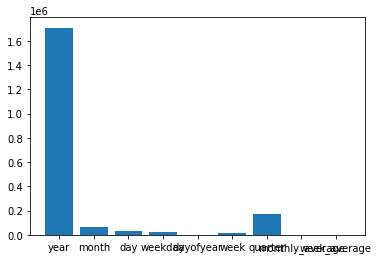

In [112]:
plt.bar(feature_coeff['Feature'], feature_coeff['coeff'])

### Random Forest

In [113]:
from sklearn.ensemble import RandomForestRegressor

In [114]:
#training the model
model = RandomForestRegressor(n_estimators=100, max_depth=7, min_samples_split = 25, random_state=0)
model.fit(x_train, y_train)
    
# predictions 
preds = model.predict(x_valid)

score = rmsle(y_valid, preds)
   
# results
print('Average Error is',score)

Average Error is 57.141254371863184


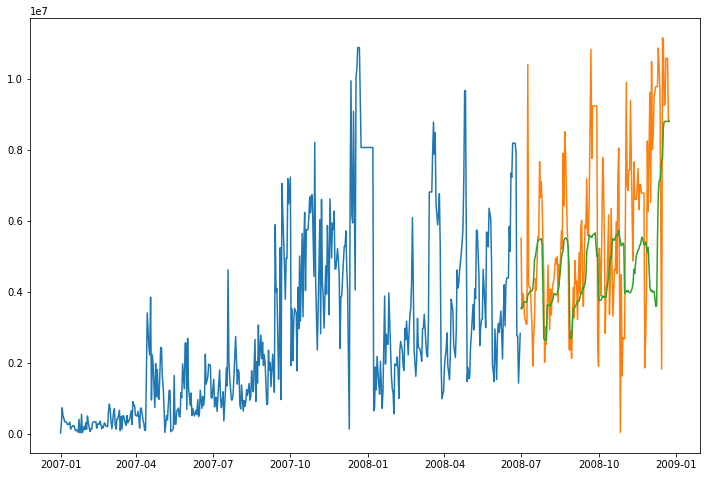

In [115]:
plt.figure(figsize = (12,8))

plt.plot(train_data.index, train_data['Number_SKU_Sold'], label = 'train')
plt.plot(valid_data.index, valid_data['Number_SKU_Sold'], label = 'valid')
plt.plot(valid_data.index, preds, label = 'preds')
plt.show()

Text(0.5, 0, 'Relative Importance')

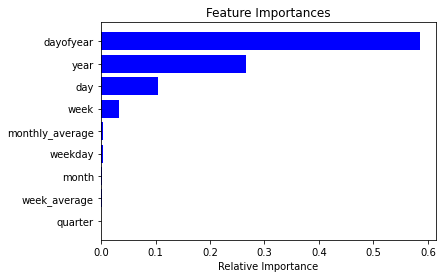

In [116]:
features = x_train.columns
importances = model.feature_importances_
indices = np.argsort(importances)

plt.figure()
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), features[indices])
plt.xlabel('Relative Importance')

# Hyperparameter Tuning

In [117]:
model = RandomForestRegressor(random_state=0)

In [118]:
# setting initial values and some bounds for them
n_estimator = [70, 100, 130, 150]
max_depth =  [5, 6, 7, 8, 9]
min_samples_split = [20, 30, 50]


# creating list with all the possible combinations of parameters
parameters = product(n_estimator, max_depth, min_samples_split)
parameters_list = list(parameters)
len(parameters_list)

60

In [119]:
def grid_search(parameters_list):
    
    results = []
    best_error_ = float("inf")

    for param in tqdm_notebook(parameters_list):
        
        #training the model
        model = RandomForestRegressor(n_estimators=param[0], max_depth=param[1], min_samples_split = param[2], random_state=0)
        model.fit(x_train, y_train)

        # predictions 
        preds = model.predict(x_valid)

        # predictions and evaluation
        score = rmsle(y_valid, preds)
        
        # saving best model, rmse and parameters
        if score < best_error_:
            best_model = model
            best_error_ = score
            best_param = param
        results.append([param, score])
        
    result_table = pd.DataFrame(results)
    result_table.columns = ['parameters', 'score']
    
    
    # sorting in ascending order, the lower rmse is - the better
    result_table = result_table.sort_values(by='score', ascending=True).reset_index(drop=True)
    
    return result_table

In [120]:
grid_search(parameters_list)

,parameters,score
0,"(150, 9, 50)",55.611651
1,"(150, 8, 50)",55.611651
2,"(150, 6, 50)",55.614266
3,"(150, 7, 50)",55.615613
4,"(130, 9, 50)",55.671246
5,"(130, 8, 50)",55.671246
6,"(130, 6, 50)",55.673594
7,"(130, 7, 50)",55.675810
8,"(100, 8, 50)",55.809698
9,"(100, 6, 50)",55.809698


In [121]:
#training the model
model = RandomForestRegressor(n_estimators=150, max_depth=9, min_samples_split = 50, random_state=0)
model.fit(x_train, y_train)
    
# predictions 
preds = model.predict(x_valid)

score = rmsle(y_valid, preds)
   
# results
print('Average Error is',score)

Average Error is 55.6116513520573


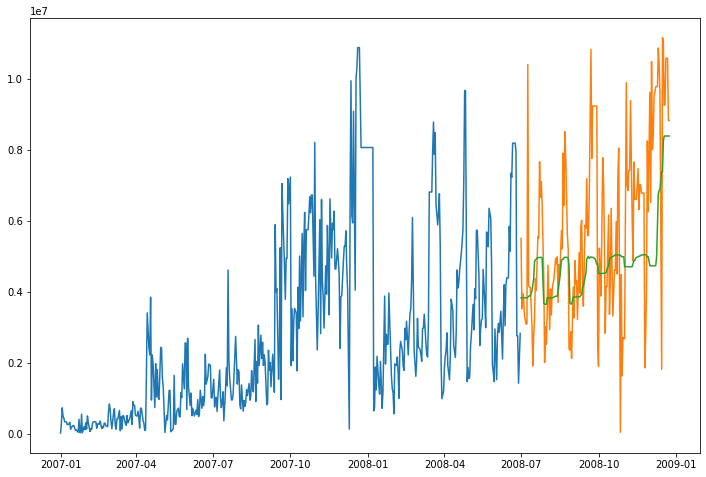

In [122]:
plt.figure(figsize = (12,8))

plt.plot(train_data.index, train_data['Number_SKU_Sold'], label = 'train')
plt.plot(valid_data.index, valid_data['Number_SKU_Sold'], label = 'valid')
plt.plot(valid_data.index, preds, label = 'preds')
plt.show()

# Forecast for next 6 months

### Preparing the Data

In [123]:
test_set = pd.DataFrame(data = pd.date_range(start = '2009-01-01', end= '2009-06-30', freq = 'D'),
                        columns=['Date'])
test_set.head()

,Date
0,2009-01-01
1,2009-01-02
2,2009-01-03
3,2009-01-04
4,2009-01-05


In [124]:
test_feat = pd.DataFrame({"Date":test_set['Date'],
                        "year": test_set['Date'].dt.year,
                          "month": test_set['Date'].dt.month,
                          "day": test_set['Date'].dt.day,
                          "weekday": test_set['Date'].dt.dayofweek,
                          "weekday_name":test_set['Date'].dt.strftime("%A"),
                          "dayofyear": test_set['Date'].dt.dayofyear,
                          "week": test_set['Date'].dt.week,
                          "quarter": test_set['Date'].dt.quarter,
                         })

In [125]:
test_feat.head()

,Date,year,month,day,weekday,weekday_name,dayofyear,week,quarter
0,2009-01-01,2009,1,1,3,Thursday,1,1,1
1,2009-01-02,2009,1,2,4,Friday,2,1,1
2,2009-01-03,2009,1,3,5,Saturday,3,1,1
3,2009-01-04,2009,1,4,6,Sunday,4,1,1
4,2009-01-05,2009,1,5,0,Monday,5,2,1


In [126]:
complete_data.head()

,year,month,day,weekday,weekday_name,dayofyear,week,quarter,Number_SKU_Sold
2007-01-01,2007,1,1,0,Monday,1,1,1,31762.0
2007-01-02,2007,1,2,1,Tuesday,2,1,1,285955.0
2007-01-03,2007,1,3,2,Wednesday,3,1,1,740781.0
2007-01-04,2007,1,4,3,Thursday,4,1,1,508796.0
2007-01-05,2007,1,5,4,Friday,5,1,1,445951.0


In [127]:
# target encoding
# month level encoding
monthly_average = pd.DataFrame(complete_data.groupby('month')['Number_SKU_Sold'].mean())
complete_data['monthly_average'] = complete_data['month'].map(monthly_average.Number_SKU_Sold)
test_feat['monthly_average'] = test_feat['month'].map(monthly_average.Number_SKU_Sold)


# week target encoding
week_average = pd.DataFrame(complete_data.groupby('weekday')['Number_SKU_Sold'].mean())
complete_data['week_average'] = complete_data['weekday'].map(week_average.Number_SKU_Sold)
test_feat['week_average'] = test_feat['weekday'].map(week_average.Number_SKU_Sold)

In [128]:
test_feat.isnull().sum()

Date                0
year                0
month               0
day                 0
weekday             0
weekday_name        0
dayofyear           0
week                0
quarter             0
monthly_average     0
week_average       26
dtype: int64

In [129]:
test_feat.dropna(axis=0, inplace = True)

In [130]:
test_set.shape, test_feat.shape

((181, 1), (155, 11))

In [131]:
x_train = complete_data.drop(['Number_SKU_Sold', 'weekday_name'], axis=1)
y_train = complete_data['Number_SKU_Sold']

x_valid = test_feat.drop(['weekday_name', 'Date'], axis=1)

### Preparing Random Forest Model

In [132]:
#training the model
model = RandomForestRegressor(n_estimators=150, max_depth=9, min_samples_split = 50, random_state=0)
model.fit(x_train, y_train)
    
# predictions 
preds = model.predict(x_valid)

In [133]:
test_feat['Number_SKU_Sold'] = preds

In [134]:
test_feat.describe()

,year,month,day,weekday,dayofyear,week,quarter,monthly_average,week_average,Number_SKU_Sold
count,155.0,155.000000,155.000000,155.000000,155.000000,155.000000,155.000000,1.550000e+02,1.550000e+02,1.550000e+02
mean,2009.0,3.503226,15.664516,2.503226,90.916129,13.916129,1.503226,2.227723e+06,3.484328e+06,3.737666e+06
std,0.0,1.722178,8.735862,1.718404,52.376008,7.491948,0.501610,4.679386e+05,1.720575e+05,1.319407e+06
min,2009.0,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.429110e+06,3.216274e+06,2.403245e+06
25%,2009.0,2.000000,8.000000,1.000000,46.000000,7.500000,1.000000,1.742686e+06,3.345490e+06,2.610024e+06
50%,2009.0,4.000000,16.000000,3.000000,91.000000,14.000000,2.000000,2.440294e+06,3.412819e+06,3.318561e+06
75%,2009.0,5.000000,23.000000,4.000000,135.500000,20.000000,2.000000,2.578959e+06,3.656954e+06,4.846462e+06
max,2009.0,6.000000,31.000000,5.000000,181.000000,27.000000,2.000000,2.748137e+06,3.669674e+06,6.272917e+06


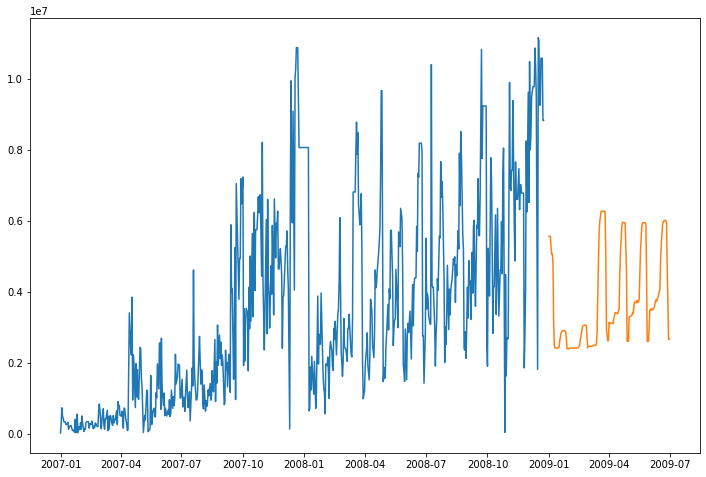

In [135]:
plt.figure(figsize = (12,8))

plt.plot(complete_data.index, complete_data['Number_SKU_Sold'], label = 'train')
plt.plot(test_feat.Date, test_feat['Number_SKU_Sold'], label = 'preds')
plt.show()

In [136]:
forecast = test_set.merge(test_feat[['Date', 'Number_SKU_Sold']], how='left', on='Date')
forecast.head()

,Date,Number_SKU_Sold
0,2009-01-01,5.564933e+06
1,2009-01-02,5.564933e+06
2,2009-01-03,5.564933e+06
3,2009-01-04,NaN
4,2009-01-05,5.066356e+06


1. Forecasts are made for all weekdays
2. Sundays in test will have 0 values

### Case 1: No Sales on a weekday

In [137]:
forecast.loc[(forecast['Date'] == '2009-01-01'), ['Number_SKU_Sold']]=0

In [138]:
forecast.head()

,Date,Number_SKU_Sold
0,2009-01-01,0.000000e+00
1,2009-01-02,5.564933e+06
2,2009-01-03,5.564933e+06
3,2009-01-04,NaN
4,2009-01-05,5.066356e+06


### Case 2: Sale on Sunday

In [139]:
data.head()

,Date,Number_SKU_Sold
Date,,
2007-01-01,2007-01-01,31762.0
2007-01-02,2007-01-02,285955.0
2007-01-03,2007-01-03,740781.0
2007-01-04,2007-01-04,508796.0
2007-01-05,2007-01-05,445951.0


In [140]:
data.shape

(587, 2)

In [141]:
data['Day'] = data['Date'].dt.strftime("%A")
data['month'] = data['Date'].dt.month

In [142]:
data.loc[data['Day'] == 'Sunday']

,Date,Number_SKU_Sold,Day,month
Date,,,,
2007-04-01,2007-04-01,59626.0,Sunday,4
2007-04-29,2007-04-29,825969.0,Sunday,4
2007-06-24,2007-06-24,632865.0,Sunday,6
2007-08-26,2007-08-26,917286.0,Sunday,8
2007-09-23,2007-09-23,2925303.0,Sunday,9
2007-12-02,2007-12-02,2491520.0,Sunday,12
2007-12-09,2007-12-09,5208565.0,Sunday,12
2007-12-16,2007-12-16,7648492.0,Sunday,12
2007-12-23,2007-12-23,10870951.0,Sunday,12


1. Replace as sales observed the same month last year
2. Percentage change in sales (compared to Saturday)

In [143]:
data.loc[(data['Date'] == '2007-06-24') | (data['Date'] == '2007-06-23')]

,Date,Number_SKU_Sold,Day,month
Date,,,,
2007-06-23,2007-06-23,1407460.0,Saturday,6
2007-06-24,2007-06-24,632865.0,Sunday,6


In [144]:
temp = data.loc[(data['Date'] == '2007-06-24') | (data['Date'] == '2007-06-23')]['Number_SKU_Sold']
temp.pct_change() 

Date
2007-06-23        NaN
2007-06-24   -0.55035
Name: Number_SKU_Sold, dtype: float64

In [145]:
test_feat['month'].value_counts()

1    27
6    26
5    26
4    26
3    26
2    24
Name: month, dtype: int64

In [146]:
test_feat[['Date', 'weekday', 'month', 'Number_SKU_Sold']].loc[(test_feat['weekday'] == 5) &(test_feat['month']== 6)]

,Date,weekday,month,Number_SKU_Sold
156,2009-06-06,5,6,3.512171e+06
163,2009-06-13,5,6,3.823422e+06
170,2009-06-20,5,6,5.911894e+06
177,2009-06-27,5,6,4.667497e+06


In [147]:
def sunday(value, pct_ch):
    val = (value*pct_ch)+value
    return val

In [148]:
sunday(3512171, -0.55)

1580476.95